# Skin Disease Image Classification and Prediction VGG-16 Model

The given dataset **Multiple Skin Disease Detectiona dn Classification**, which includes nine categories:
1. Acitinic Keratosis
2. Basal Cell Carcinoma
3. Dermatofibroma
4. Melanoma
5. Nevus
6. Pigmented Benign Keratosis
7. Seborrheic Keratosis
8. Squamous Cell Carcinoma
9. Vascular Lesion

These differrent skin condition, all of them are not cancerous. Some of them are Cancerous, few are Precancerous and Most of them are Non-Cancerous.

**Cancerous:**
- Basal Cell Carcinoma
- Melanoma
- Squamous Cell Carcinoma

**Precancerous:**
- Acitinic Keratosis (can be cancerous if left untreated)

**Benign or Non-Cancerous:**
- Dermatofibroma
- Nevus
- Pigmented Benign Keratosis
- Seborrheic Keratosis
- Vascular Lesion

## Note
Previous Notebook was just knowing introduction to dataset and model and how we can implement this so far.
We get to know that dataset is not that much promising and also number of classes is enough to destroy the accuracy of the model. 

- In this Notebook going to train the model more with Data Augmentation and 
- Implement VGG19 model using Transfer Learning

# 1. Import Libraries and Dependencies

In [12]:
import os
import shutil
import random
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
from PIL import Image, ImageEnhance, ImageFilter
import math
from math import floor
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_auc_score
import tensorflow as tf
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Flatten, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
%matplotlib inline

# 2. Know You Dataset

In [13]:
def display_data(parent_dir):
    # Step 1: Directory to disease mapping
    condition_types = {
        'Acitinic Keratosis': 'Precancerous',
        'Basal Cell Carcinoma': 'Cancerous',
        'Dermatofibroma': 'Non-cancerous',
        'Melanoma': 'Cancerous',
        'Nevus': 'Non-cancerous',
        'Pigmented Benign Keratosis': 'Non-cancerous',
        'Seborrheic Keratosis': 'Non-cancerous',
        'Squamous Cell Carcinoma': 'Cancerous',
        'Vascular Lesion': 'Non-cancerous'
    }

    # Step 2: Create a DataFrame with directory names and image counts
    data = {'Directory': [], 'File Count': [], 'Condition Type': []}

    # Step 3: Loop through directories, count images, and add condition type
    for dirpath, dirnames, filenames in os.walk(parent_dir):
        if dirpath != parent_dir:
            dir_name = os.path.basename(dirpath)
            file_count = len(filenames)
            condition_type = condition_types.get(dir_name, 'Unknown')  # Get the condition type from the mapping
            data['Directory'].append(dir_name)
            data['File Count'].append(file_count)
            data['Condition Type'].append(condition_type)

    # Create DataFrame
    df = pd.DataFrame(data)
    # Step 4: Add the color mapping
    colors = {'Cancerous': 'red', 'Precancerous': 'yellow', 'Non-cancerous': 'green'}

    # Set up the bar plot
    plt.figure(figsize=(10,6))
    bars = plt.bar(df['Directory'], df['File Count'], color=[colors[ctype] for ctype in df['Condition Type']])

    # Add title and labels
    plt.title('Number of Image per Skin Condition', fontsize=14)
    plt.xlabel('Skin Disease', fontsize=12)
    plt.ylabel('Image Count', fontsize=12)

    # Add a legend
    handles = [plt.Rectangle((0,0),1,1, color=color) for color in colors.values()]
    labels = colors.keys()
    plt.legend(handles, labels, title="Condition Type")

    # Show the plot
    plt.xticks(rotation=45, ha="right")  # Rotate x-axis labels for readability
    plt.tight_layout()
    plt.show()

## 2.1. Number of Images in Each Category

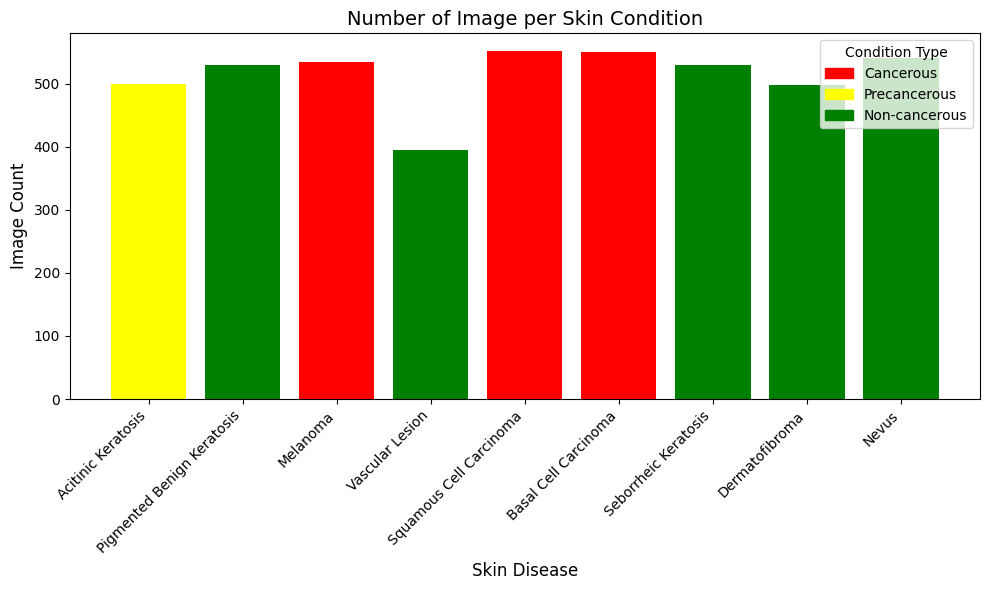

In [15]:
display_data(parent_dir = '/kaggle/input/skin-cancer-dataset-vgg/Skin Cancer Dataset')

## 2.2. Visualizing the Images of Skin Diseases

Displaying images for category: Acitinic Keratosis


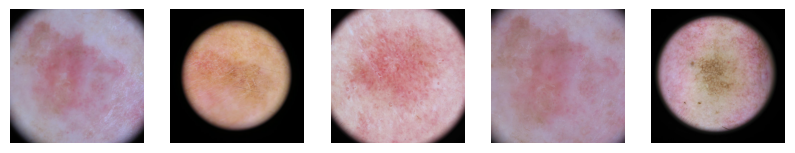

Displaying images for category: Pigmented Benign Keratosis


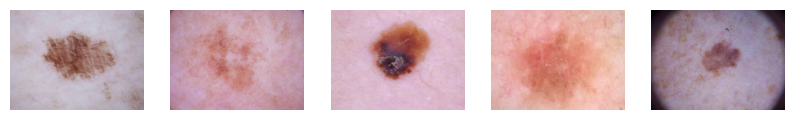

Displaying images for category: Melanoma


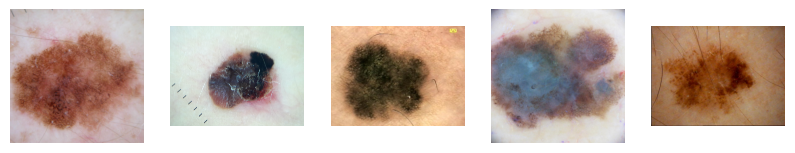

Displaying images for category: Vascular Lesion


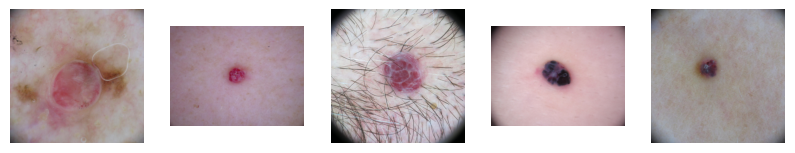

Displaying images for category: Squamous Cell Carcinoma


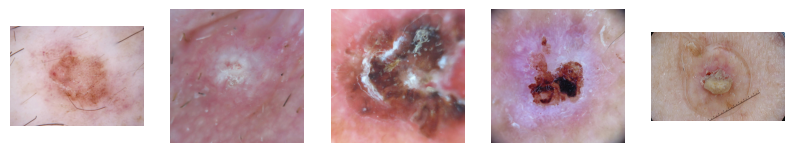

Displaying images for category: Basal Cell Carcinoma


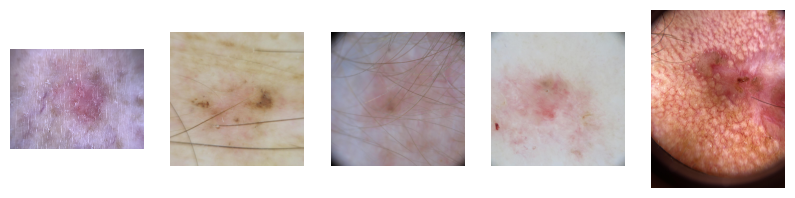

Displaying images for category: Seborrheic Keratosis


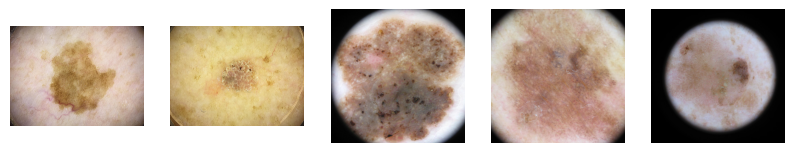

Displaying images for category: Dermatofibroma


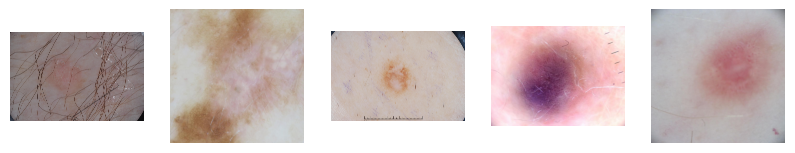

Displaying images for category: Nevus


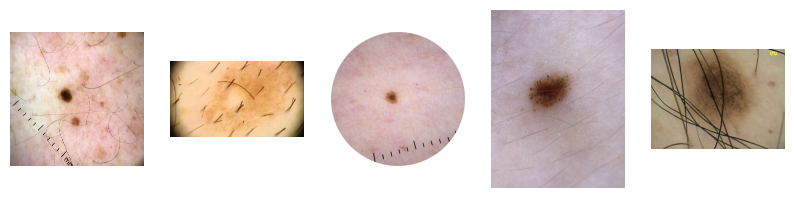

In [16]:
parent_dir = '/kaggle/input/skin-cancer-dataset-vgg/Skin Cancer Dataset'

# Automatically retrieve the list of categories (subdirectories) from the parent directory
categories = [d for d in os.listdir(parent_dir) if os.path.isdir(os.path.join(parent_dir, d))]

# Function to display images from each category
def display_images_for_category(category_dir, num_images=5):
    image_files = [f for f in os.listdir(category_dir)]
    
    # Only proceed if there are images to display
    if len(image_files) == 0:
        print(f"No images found in {category_dir}. Skipping...")
        return
    
    # Display at least 5 images or all if fewer are available
    image_files = image_files[:num_images]
    
    # Set up the figure to display images
    fig, axes = plt.subplots(1, len(image_files), figsize=(10, 5))
    
    # If there's only one image, axes is not a list, handle that case
    if len(image_files) == 1:
        axes = [axes]
    
    # Display each image
    for i, image_file in enumerate(image_files):
        img_path = os.path.join(category_dir, image_file)
        img = mpimg.imread(img_path)
        axes[i].imshow(img)
        axes[i].axis('off')  # Hide axes
#         axes[i].set_title(f'{os.path.basename(category_dir)}')

    plt.show()

# Loop through each category and display at least 5 images
for category in categories:
    category_dir = os.path.join(parent_dir, category)
    if os.path.exists(category_dir):  # Check if the directory exists
        print(f"Displaying images for category: {category}")
        display_images_for_category(category_dir, num_images=5)
    else:
        print(f"Directory not found: {category_dir}")

## 2.3. Image Information

In [18]:
def get_image_properties(image_path):
    try:
        # Open the image file
        with Image.open(image_path) as img:
            # Get image properties
            properties = {
                'Filename': os.path.basename(image_path),
                'Format': img.format,
                'Mode': img.mode,
                'Size': img.size,  # (width, height)
                'Width': img.width,
                'Height': img.height,
                'Info': img.info,  # Additional metadata
            }
            # Convert the image to a NumPy array for displaying
            img_array = np.array(img)
            return properties, img_array  # Return properties and image array
    except Exception as e:
        print(f"Error opening image: {e}")
        return None, None

def display_image(image):
    plt.imshow(image)
    plt.axis('off')  # Hide axes
    plt.show()

# Example usage
image_path = "/kaggle/input/multiple-skin-disease-detection-and-classification/Skin Cancer Dataset/kaggle/input/skin-cancer-dataset-vgg/Skin Cancer Dataset/Melanoma/ISIC_0066262.JPG"  # Specify image path
properties, image = get_image_properties(image_path)

if properties:
    print("Image Properties:")
    for key, value in properties.items():
        print(f"{key}: {value}")
    
    # Display the image
    display_image(image)


Error opening image: [Errno 2] No such file or directory: '/kaggle/input/multiple-skin-disease-detection-and-classification/Skin Cancer Dataset/kaggle/input/skin-cancer-dataset-vgg/Skin Cancer Dataset/Melanoma/ISIC_0066262.JPG'


# 3 Data Augmentation

## 3.1. Image Resizng (224, 224, 3)

In [20]:
# Define the paths
source_directory = '/kaggle/input/skin-cancer-dataset-vgg/Skin Cancer Dataset'  # Source dataset directory containing class subdirectories
target_directory = '/kaggle/working/Dataset'  # Target directory to save resized images
target_size = (224, 224)  # Target size for resizing

# Create the target directory if it doesn't exist
if not os.path.exists(target_directory):
    os.makedirs(target_directory)

# Function to resize images and save them in the target directory
def resize_images_and_save(source_dir, target_dir, size):
    # Loop through each subdirectory (class) in the source directory
    for class_dir in os.listdir(source_dir):
        class_path = os.path.join(source_dir, class_dir)
        target_class_path = os.path.join(target_dir, class_dir)

        if os.path.isdir(class_path):  # Check if it's a directory (class)
            # Create the corresponding class directory in the target directory
            if not os.path.exists(target_class_path):
                os.makedirs(target_class_path)

            print(f"Processing class: {class_dir}")

            # Loop through each image file in the class directory
            for filename in os.listdir(class_path):
                img_path = os.path.join(class_path, filename)
                target_img_path = os.path.join(target_class_path, filename)

                try:
                    # Open and resize the image
                    with Image.open(img_path) as img:
                        resized_img = img.resize(size)

                        # Save the resized image to the target directory
                        resized_img.save(target_img_path)
#                         print(f"Resized and saved {filename} to {target_img_path}")

                except Exception as e:
                    print(f"Error processing file {filename}: {e}")

# Call the function to resize images and save them to the target directory
resize_images_and_save(source_directory, target_directory, target_size)

Processing class: Acitinic Keratosis
Processing class: Pigmented Benign Keratosis
Processing class: Melanoma
Processing class: Vascular Lesion
Processing class: Squamous Cell Carcinoma
Processing class: Basal Cell Carcinoma
Processing class: Seborrheic Keratosis
Processing class: Dermatofibroma
Error processing file metadata.csv: cannot identify image file '/kaggle/input/skin-cancer-dataset-vgg/Skin Cancer Dataset/Dermatofibroma/metadata.csv'
Processing class: Nevus


## 3.2. Visualizing Resized Skin Disease Images

Displaying images for category: Dermatofibroma


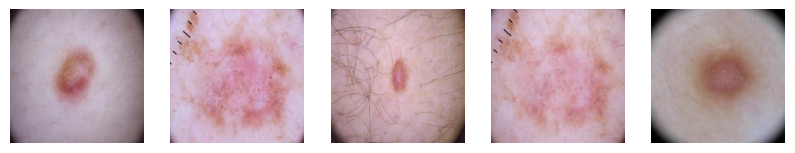

Displaying images for category: Squamous Cell Carcinoma


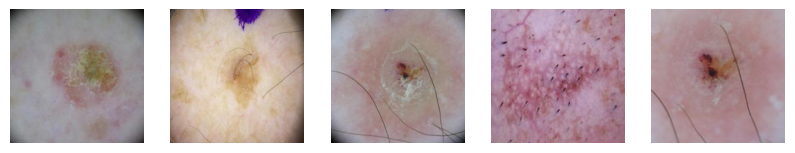

Displaying images for category: Pigmented Benign Keratosis


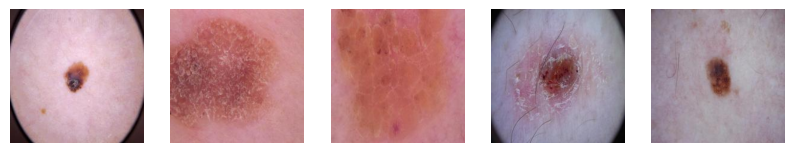

Displaying images for category: Melanoma


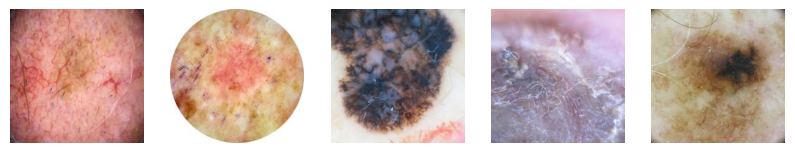

Displaying images for category: Vascular Lesion


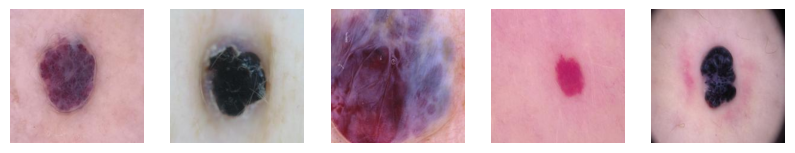

Displaying images for category: Basal Cell Carcinoma


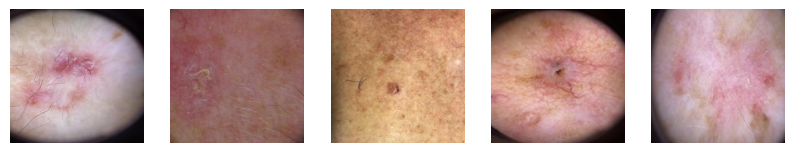

Displaying images for category: Acitinic Keratosis


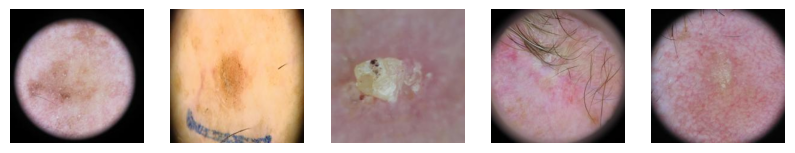

Displaying images for category: Nevus


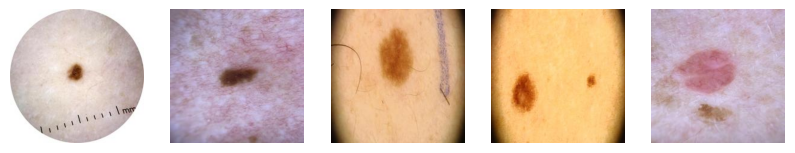

Displaying images for category: Seborrheic Keratosis


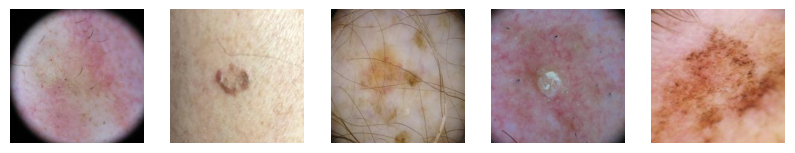

In [21]:
parent_dir = '/kaggle/working/Dataset'

# Automatically retrieve the list of categories (subdirectories) from the parent directory
categories = [d for d in os.listdir(parent_dir) if os.path.isdir(os.path.join(parent_dir, d))]

# Function to display images from each category
def display_images_for_category(category_dir, num_images=5):
    image_files = [f for f in os.listdir(category_dir)]
    
    # Only proceed if there are images to display
    if len(image_files) == 0:
        print(f"No images found in {category_dir}. Skipping...")
        return
    
    # Display at least 5 images or all if fewer are available
    image_files = image_files[:num_images]
    
    # Set up the figure to display images
    fig, axes = plt.subplots(1, len(image_files), figsize=(10, 5))
    
    # If there's only one image, axes is not a list, handle that case
    if len(image_files) == 1:
        axes = [axes]
    
    # Display each image
    for i, image_file in enumerate(image_files):
        img_path = os.path.join(category_dir, image_file)
        img = mpimg.imread(img_path)
        axes[i].imshow(img)
        axes[i].axis('off')  # Hide axes
#         axes[i].set_title(f'{os.path.basename(category_dir)}')

    plt.show()

# Loop through each category and display at least 5 images
for category in categories:
    category_dir = os.path.join(parent_dir, category)
    if os.path.exists(category_dir):  # Check if the directory exists
        print(f"Displaying images for category: {category}")
        display_images_for_category(category_dir, num_images=5)
    else:
        print(f"Directory not found: {category_dir}")

## 3.3. Image Aumentation
Image Augmentation includes:
1. Horizontal Flip
2. Vertical Flip
3. Random Rotation (Between -30 to 30 degree)
4. Random Contrast Adjustment
5. Gaussain Blur


In [22]:
# Define the paths
source_directory = '/kaggle/working/Dataset'  # Source dataset directory containing class subdirectories
target_directory = '/kaggle/working/Data_Augmentation'  # Target directory to save augmented images

# Create the target directory if it doesn't exist
if not os.path.exists(target_directory):
    os.makedirs(target_directory)

# Data augmentation function
def augment_image(img):
    # List of augmentation transformations
    augmentations = [
        lambda x: x.transpose(Image.FLIP_LEFT_RIGHT),  # Horizontal flip
        lambda x: x.transpose(Image.FLIP_TOP_BOTTOM),  # Vertical flip
        lambda x: x.rotate(random.randint(-30, 30)),   # Random rotation between -30 to 30 degrees
        lambda x: ImageEnhance.Brightness(x).enhance(random.uniform(0.7, 1.3)),  # Random brightness adjustment
        lambda x: ImageEnhance.Contrast(x).enhance(random.uniform(0.7, 1.3)),    # Random contrast adjustment
        lambda x: ImageEnhance.Color(x).enhance(random.uniform(0.7, 1.3)),       # Random saturation adjustment
        lambda x: x.filter(ImageFilter.GaussianBlur(radius=random.uniform(0, 2)))  # Gaussian blur
    ]
    
    # Randomly apply 2-3 augmentations
    aug_img = img.copy()
    for _ in range(random.randint(2, 3)):
        aug_img = random.choice(augmentations)(aug_img)

    return aug_img

# Function to perform data augmentation on all images and save them
def augment_images_and_save(source_dir, target_dir, augmentations_per_image=7):
    # Loop through each subdirectory (class) in the source directory
    for class_dir in os.listdir(source_dir):
        class_path = os.path.join(source_dir, class_dir)
        target_class_path = os.path.join(target_dir, class_dir)

        if os.path.isdir(class_path):  # Check if it's a directory (class)
            # Create the corresponding class directory in the target directory
            if not os.path.exists(target_class_path):
                os.makedirs(target_class_path)

            print(f"Processing class: {class_dir}")

            # Loop through each image file in the class directory
            for filename in os.listdir(class_path):
                img_path = os.path.join(class_path, filename)
                base, ext = os.path.splitext(filename)

                try:
                    # Open the original image
                    with Image.open(img_path) as img:
                        # Save the original image to the target directory
                        original_img_path = os.path.join(target_class_path, f"{base}_original{ext}")
                        img.save(original_img_path)
#                         print(f"Saved original image: {base}_original{ext}")

                        # Generate augmented images
                        for i in range(augmentations_per_image):
                            aug_img = augment_image(img)
                            aug_img.save(os.path.join(target_class_path, f"{base}_augmented_{i+1}{ext}"))
#                             print(f"Saved {base}_augmented_{i+1}{ext}")

                except Exception as e:
                    print(f"Error processing file {filename}: {e}")

# Call the function to perform augmentation on all images
augment_images_and_save(source_directory, target_directory, augmentations_per_image=7)

Processing class: Dermatofibroma
Processing class: Squamous Cell Carcinoma
Processing class: Pigmented Benign Keratosis
Processing class: Melanoma
Processing class: Vascular Lesion
Processing class: Basal Cell Carcinoma
Processing class: Acitinic Keratosis
Processing class: Nevus
Processing class: Seborrheic Keratosis


## 3.4. Splitting the Dataset into Train, Test and Validation

In [23]:
def split_dataset(dataset_dir, output_dir, train_ratio=0.8, val_ratio=0.1, test_ratio=0.1):
    # Create output directories for train, val, test sets
    train_dir = os.path.join(output_dir, 'Train')
    val_dir = os.path.join(output_dir, 'Validation')
    test_dir = os.path.join(output_dir, 'Test')

    os.makedirs(train_dir, exist_ok=True)
    os.makedirs(val_dir, exist_ok=True)
    os.makedirs(test_dir, exist_ok=True)

    # Loop through each class (directory) in the dataset
    for class_name in os.listdir(dataset_dir):
        class_dir = os.path.join(dataset_dir, class_name)
        if not os.path.isdir(class_dir):
            continue
        
        # List all image files in the class directory
        image_files = os.listdir(class_dir)
        
        # Shuffle the images randomly
        random.shuffle(image_files)
        
        # Calculate the split indices
        total_images = len(image_files)
        train_count = floor(total_images * train_ratio)
        val_count = floor(total_images * val_ratio)
        test_count = total_images - train_count - val_count  # The rest goes to test

        # Split the images
        train_files = image_files[:train_count]
        val_files = image_files[train_count:train_count + val_count]
        test_files = image_files[train_count + val_count:]

        # Copy files to the appropriate directories
        for file in train_files:
            src = os.path.join(class_dir, file)
            dest = os.path.join(train_dir, class_name)
            os.makedirs(dest, exist_ok=True)
            shutil.copy(src, dest)

        for file in val_files:
            src = os.path.join(class_dir, file)
            dest = os.path.join(val_dir, class_name)
            os.makedirs(dest, exist_ok=True)
            shutil.copy(src, dest)

        for file in test_files:
            src = os.path.join(class_dir, file)
            dest = os.path.join(test_dir, class_name)
            os.makedirs(dest, exist_ok=True)
            shutil.copy(src, dest)

    print("Dataset successfully split into train, validation, and test sets.")

#  Usage
dataset_dir = '/kaggle/working/Data_Augmentation' 
output_dir = '/kaggle/working/'

split_dataset(dataset_dir, output_dir)

Dataset successfully split into train, validation, and test sets.


## 3.5. Train Dataset

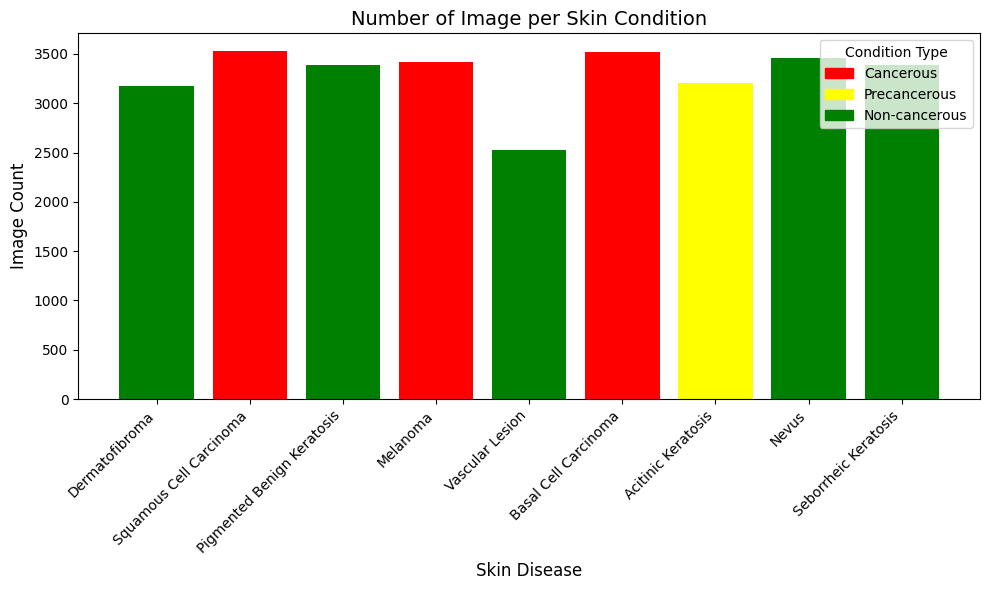

In [24]:
display_data(parent_dir = '/kaggle/working/Train')

## 3.6. Validation Dataset

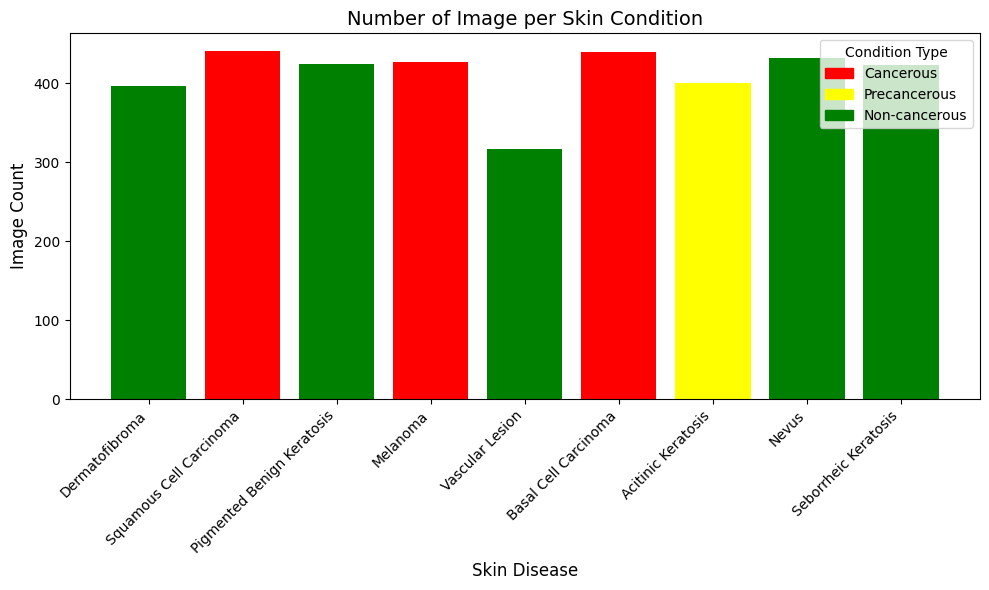

In [25]:
display_data(parent_dir = '/kaggle/working/Validation')

## 3.7. Testing Dataset

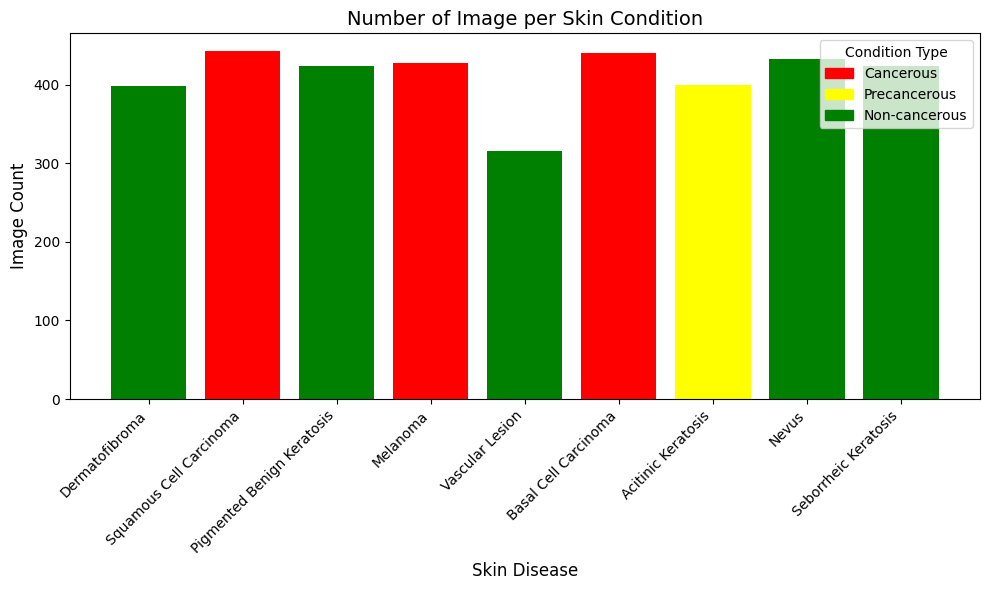

In [26]:
display_data(parent_dir = '/kaggle/working/Test')

## 3.8. Display Data Augmentated Skin Disease Images

Displaying images for category: Dermatofibroma


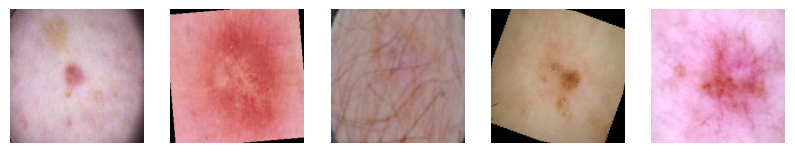

Displaying images for category: Squamous Cell Carcinoma


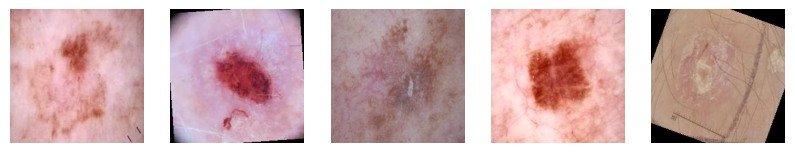

Displaying images for category: Pigmented Benign Keratosis


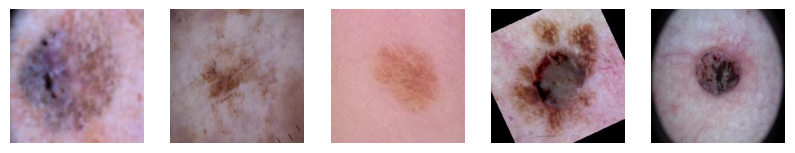

Displaying images for category: Melanoma


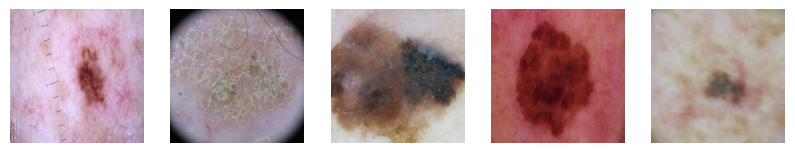

Displaying images for category: Vascular Lesion


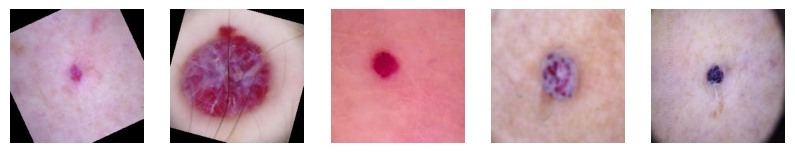

Displaying images for category: Basal Cell Carcinoma


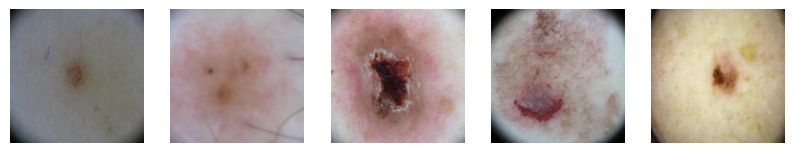

Displaying images for category: Acitinic Keratosis


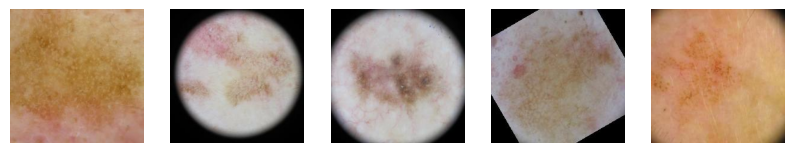

Displaying images for category: Nevus


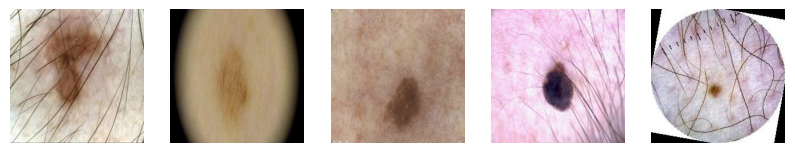

Displaying images for category: Seborrheic Keratosis


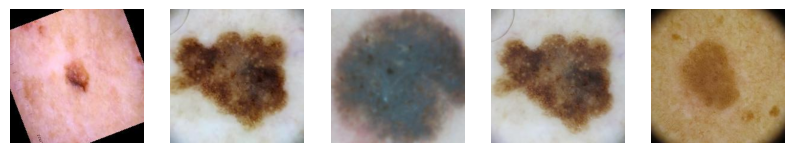

In [27]:
parent_dir = '/kaggle/working/Data_Augmentation'

# Automatically retrieve the list of categories (subdirectories) from the parent directory
categories = [d for d in os.listdir(parent_dir) if os.path.isdir(os.path.join(parent_dir, d))]

# Function to display images from each category
def display_images_for_category(category_dir, num_images=10):
    image_files = [f for f in os.listdir(category_dir)]
    
    # Only proceed if there are images to display
    if len(image_files) == 0:
        print(f"No images found in {category_dir}. Skipping...")
        return
    
    # Display at least 5 images or all if fewer are available
    image_files = image_files[:num_images]
    
    # Set up the figure to display images
    fig, axes = plt.subplots(1, len(image_files), figsize=(10, 5))
    
    # If there's only one image, axes is not a list, handle that case
    if len(image_files) == 1:
        axes = [axes]
    
    # Display each image
    for i, image_file in enumerate(image_files):
        img_path = os.path.join(category_dir, image_file)
        img = mpimg.imread(img_path)
        axes[i].imshow(img)
        axes[i].axis('off')  # Hide axes
#         axes[i].set_title(f'{os.path.basename(category_dir)}')

    plt.show()

# Loop through each category and display at least 5 images
for category in categories:
    category_dir = os.path.join(parent_dir, category)
    if os.path.exists(category_dir):  # Check if the directory exists
        print(f"Displaying images for category: {category}")
        display_images_for_category(category_dir, num_images=5)
    else:
        print(f"Directory not found: {category_dir}")

# 4. Loading Dataset

In [29]:
# Directories for train, validation, and test sets
train_dir = '/kaggle/working/Train'
val_dir = '/kaggle/working/Validation'
test_dir = '/kaggle/working/Test'

# Create an ImageDataGenerator for each set
# The rescale parameter normalizes pixel values from [0, 255] to [0, 1]
train_datagen = ImageDataGenerator(rescale=1./255)
val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

# Load and normalize the training data
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),  # Resize all images to 224x224
    batch_size=32,  # Number of images per batch
    class_mode='categorical'  # Adjust if your labels are binary or categorical
)

# Load and normalize the validation data
val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

# Load and normalize the test data
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=False  # Shuffle should be False for test set to ensure proper evaluation
)

Found 29604 images belonging to 9 classes.
Found 3699 images belonging to 9 classes.
Found 3705 images belonging to 9 classes.


# 5. VGG16 Model

In [30]:
# Load the VGG16 model, excluding the top fully connected layers
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the base model layers to retain pre-trained weights
for layer in base_model.layers:
    layer.trainable = False

# Add custom fully connected layers on top of VGG16 base
x = base_model.output
x = Flatten()(x)  # Flatten the output from convolutional layers
x = Dense(512, activation='relu')(x)  # Fully connected layer with 512 units
x = Dropout(0.2)(x)  # Dropout for regularization
x = Dense(256, activation='relu')(x)  # Another fully connected layer with 256 units
x = Dropout(0.1)(x)

# Output layer with 'softmax' activation for multi-class classification
# There are 9 classes (for 9 skin diseases)
output_layer = Dense(9, activation='softmax')(x)

# Create the full model
model = Model(inputs=base_model.input, outputs=output_layer)

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.0001), 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

# Summary of the model
model.summary()

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │    12,845,568 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 9)              │         2,31

 Total params: 27,693,897 (105.64 MB)

 Trainable params: 12,979,209 (49.51 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [31]:
import tensorflow as tf

# Check if TensorFlow is using GPU
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  1


# 6. Model Training

In [36]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# Path to save the best model
checkpoint_path = "best_model_vgg16.keras"

# Define early stopping callback
early_stop = EarlyStopping(
    monitor='val_accuracy',
    patience=10,
    restore_best_weights=True
)

# Define model checkpoint callback to save the best model based on validation accuracy
checkpoint = ModelCheckpoint(
    filepath=checkpoint_path,
    monitor='val_accuracy',
    save_best_only=True,
    save_weights_only=False,  # Save entire model, not just weights
    mode='max',
    verbose=1
)

# Train the model with both callbacks
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    validation_data=val_generator,
    validation_steps=val_generator.samples // val_generator.batch_size,
    epochs=40,
    callbacks=[early_stop, checkpoint]
)


Epoch 1/40
925/925 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - accuracy: 0.8927 - loss: 0.3033
Epoch 1: val_accuracy improved from -inf to 0.79457, saving model to best_model_vgg16.keras
925/925 ━━━━━━━━━━━━━━━━━━━━ 70s 76ms/step - accuracy: 0.8927 - loss: 0.3033 - val_accuracy: 0.7946 - val_loss: 0.6626
Epoch 2/40
  1/925 ━━━━━━━━━━━━━━━━━━━━ 58s 64ms/step - accuracy: 0.9062 - loss: 0.2741
Epoch 2: val_accuracy did not improve from 0.79457
925/925 ━━━━━━━━━━━━━━━━━━━━ 0s 64us/step - accuracy: 0.9062 - loss: 0.2741 - val_accuracy: 0.7368 - val_loss: 0.8804
Epoch 3/40
925/925 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - accuracy: 0.8927 - loss: 0.3000
Epoch 3: val_accuracy improved from 0.79457 to 0.79918, saving model to best_model_vgg16.keras
925/925 ━━━━━━━━━━━━━━━━━━━━ 70s 76ms/step - accuracy: 0.8927 - loss: 0.3000 - val_accuracy: 0.7992 - val_loss: 0.6976
Epoch 4/40
  1/925 ━━━━━━━━━━━━━━━━━━━━ 59s 64ms/step - accuracy: 0.9688 - loss: 0.1358
Epoch 4: val_accuracy improved from 0.79918 to 0.94737, 

# 7. Model Evaluation

## 7.1. Testing Accuracy

In [37]:
# Evaluate on the test set
test_loss, test_acc = model.evaluate(test_generator)
print(f"Test Accuracy: {test_acc * 100:.2f}%")

116/116 ━━━━━━━━━━━━━━━━━━━━ 13s 114ms/step - accuracy: 0.8159 - loss: 0.6486
Test Accuracy: 80.32%


## 7.2. Visualizing Training and Validation Accuracy and Loss

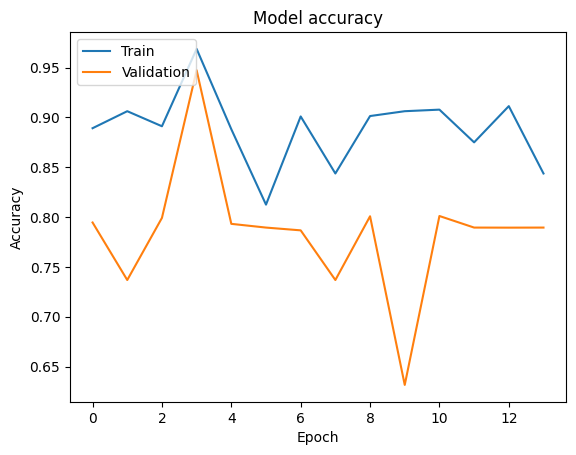

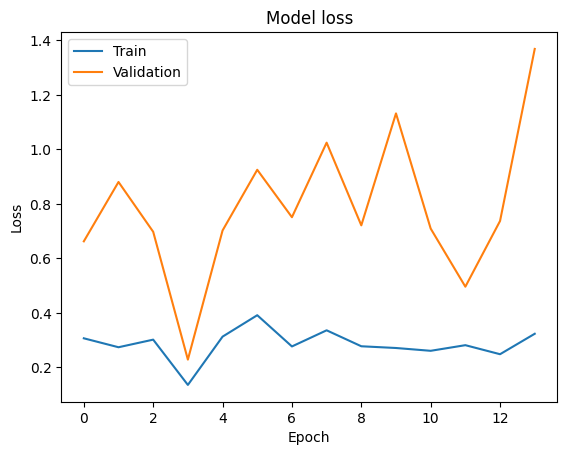

In [38]:
# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

## 7.3. Confusion Matrix

116/116 ━━━━━━━━━━━━━━━━━━━━ 8s 64ms/step
Length of true labels (y_true): 3705
Length of predicted labels (y_pred): 3705
                            precision    recall  f1-score   support

        Acitinic Keratosis       0.77      0.83      0.80       400
      Basal Cell Carcinoma       0.72      0.75      0.73       440
            Dermatofibroma       0.67      0.86      0.76       398
                  Melanoma       0.87      0.79      0.82       428
                     Nevus       0.88      0.93      0.90       432
Pigmented Benign Keratosis       0.90      0.79      0.84       424
      Seborrheic Keratosis       0.73      0.75      0.74       424
   Squamous Cell Carcinoma       0.85      0.73      0.79       443
           Vascular Lesion       0.96      0.82      0.88       316

                  accuracy                           0.80      3705
                 macro avg       0.82      0.80      0.81      3705
              weighted avg       0.81      0.80      0.80    

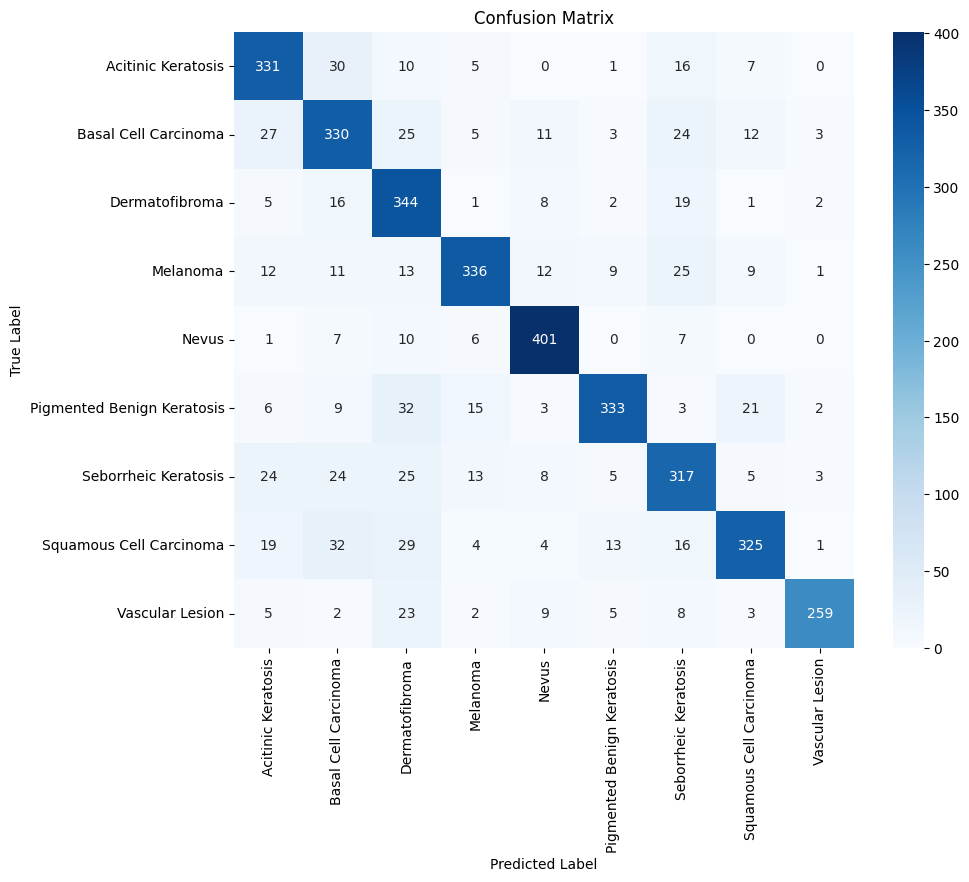

In [39]:
# Ensure the generator is reset
test_generator.reset()

# Calculate the correct number of steps
test_steps = math.ceil(test_generator.samples / test_generator.batch_size)

# Make predictions
predictions = model.predict(test_generator, steps=test_steps, verbose=1)

# Convert predicted probabilities to class labels
y_pred = np.argmax(predictions, axis=1)

# Get the true labels
y_true = test_generator.classes

# Check if the lengths of y_true and y_pred are consistent
print(f"Length of true labels (y_true): {len(y_true)}")
print(f"Length of predicted labels (y_pred): {len(y_pred)}")

# Ensure the length of y_true and y_pred match
if len(y_true) != len(y_pred):
    raise ValueError(f"Mismatch in number of true labels and predicted labels: {len(y_true)} vs {len(y_pred)}")

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)

# Classification report
print(classification_report(y_true, y_pred, target_names=test_generator.class_indices.keys()))

# Plotting confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=test_generator.class_indices.keys(), yticklabels=test_generator.class_indices.keys())
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

## 7.4. ROC Curve

116/116 ━━━━━━━━━━━━━━━━━━━━ 7s 60ms/step


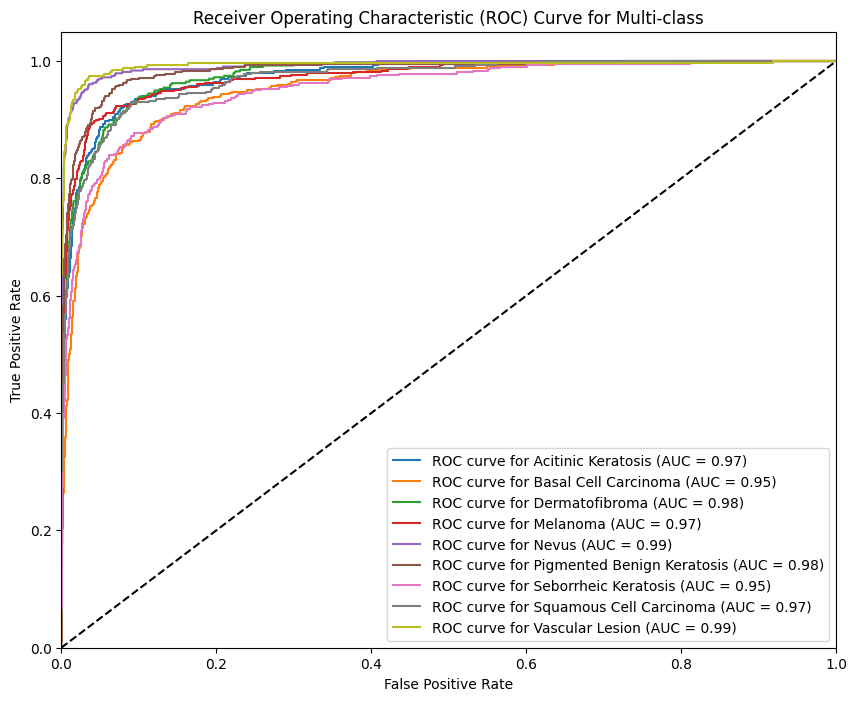

In [40]:
# Reset the test generator and predict on the test data
test_generator.reset()
test_steps = math.ceil(test_generator.samples / test_generator.batch_size)
y_pred_probs = model.predict(test_generator, steps=test_steps, verbose=1)

# Convert the true labels to a binary matrix format (one-vs-all)
y_true = test_generator.classes
n_classes = len(test_generator.class_indices)

# Binarize the labels
y_true_bin = label_binarize(y_true, classes=list(range(n_classes)))

# Generate ROC curve for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], y_pred_probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curve for each class
plt.figure(figsize=(10, 8))
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], label=f'ROC curve for {list(test_generator.class_indices.keys())[i]} (AUC = {roc_auc[i]:0.2f})')

# Plot diagonal line for random classifier (no discrimination)
plt.plot([0, 1], [0, 1], 'k--')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve for Multi-class')
plt.legend(loc='lower right')
plt.show()